In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.testing import *
from pdb import set_trace
import direct
from direct.misc import RBF_RFFs, KronMatrix, KhatriRaoMeshgrid, log_softmax
import tensorflow as tf

# Two Parameter Model

## Mean Field Variational Distribution
### Ensure ELBO computed Correctly
compute the exact ELBO with the initialized mean-field variational distribution and check if correct.

In [2]:
np.random.seed(0)

# create a fake dataset
n = 50
sig2_grid = np.atleast_1d([0.01, 0.02])
x = np.random.rand(n,1);
Phi = np.hstack((x, np.ones(x.shape)))
xx = np.linspace(0,1,num=50).reshape((-1,1))
Phi_X = np.hstack((xx, np.ones(xx.shape)))
w_exact = 1.
y = w_exact*np.sum(Phi,axis=1,keepdims=True)
y += np.random.normal(size=(n,1), scale=np.sqrt(sig2_grid[0])) # add some noise

# initialize the W grid, and the prior / variational distibution
wbar = [-1.,-0.5,0.,0.5,1.]
Wbar = np.array([wbar,]*Phi.shape[1])
mbar = Wbar.shape[1]
W = KhatriRaoMeshgrid(Wbar).expand()
sig2_biggrid = np.tile(sig2_grid.reshape((-1,1)),(1,W.shape[1])).reshape(-1) # the sig2 elements correspond to W cols
W = np.tile(W,(1,sig2_grid.size)) # W is repeated the number of times for sig2
P = np.zeros((Phi.shape[1], mbar)) + 1./mbar # prior for weights
psig = np.zeros(sig2_grid.shape) + 1./sig2_grid.size # prior for sig2

# compute the exact log-likelihood
logl_exact = np.zeros((W.shape[1],1))
for i,(w,sig2) in enumerate(zip(W.T, sig2_biggrid)): # loop through each possible set of parameters
    logl_exact[i] = -np.sum(np.power(y-Phi.dot(w.reshape((-1,1))), 2))/(2.*sig2) - n*np.log(sig2)/2
del sig2

# now initialize the model and compute the ELBO with a random initial variational distribution
with tf.Session() as sess:
    m = direct.BayesGLM(Phi=Phi, sig2_grid=sig2_grid, y=y, Wbar=Wbar, logP=np.log(P), logpsig=np.log(psig),
                 logQ=np.random.randn(*P.shape), logqsig=np.random.randn(*psig.shape))
    sess.run(tf.global_variables_initializer())
    assert_array_almost_equal(np.ones(m.b), sess.run(tf.reduce_sum(tf.exp(m.logQ), axis=1)),
                             err_msg="Var dist not normalized correctly.")
    ELBO = sess.run(m.ELBO)
    Q = sess.run(tf.exp(m.logQ))
    qsig = sess.run(tf.exp(m.logqsig))

    # compute the ELBO manually
    prior_expanded = np.kron(psig.reshape((-1,1)), KronMatrix(np.expand_dims(P, axis=2)).expand())
    q_expanded = np.kron(qsig, KronMatrix(np.expand_dims(Q,axis=2)).expand())
    ELBO_exact = q_expanded.T.dot(np.log(prior_expanded) - np.log(q_expanded) + logl_exact)

    assert_array_almost_equal(ELBO_exact, ELBO, err_msg="ELBO not computed exactly")
print("test passed.")

[ 17:20:58 ] direct.models INFO: Inititializing model
test passed.


### Optimize
Optimize the variational distribution and ensure it is larger than the initial ELBO

In [3]:
with tf.Session() as sess:
    # reinitialize the model and compute the ELBO with initial variational distribution set to prior
    m = direct.BayesGLM(Phi=Phi, sig2_grid=sig2_grid, y=y, Wbar=Wbar, logP=np.log(P), logpsig=np.log(psig))
    sess.run(tf.global_variables_initializer())
    trace = m.train(n_epochs=1000, sess=sess, display_step=5)
    assert_array_less(ELBO, sess.run(m.ELBO), err_msg="ELBO did not increase in training")
    Q = sess.run(tf.exp(m.logQ))
    qsig = sess.run(tf.exp(m.logqsig))
    y_mean = sess.run(m.predict_mean(Phi_X=Phi_X))

[ 17:20:58 ] direct.models INFO: Inititializing model
[ 17:20:58 ] direct.models INFO: Beginnning training iterations. n_epochs=1000
[ 17:20:58 ] direct.models INFO: using L-BFGS-B optimizer
Epoch: 0001, ELBO: -5654.5434, Time elapsed: 0.06252 seconds.
Epoch: 0005, ELBO: -61.437337, Time elapsed: 0.06639 seconds.
Epoch: 0010, ELBO: 79.270504, Time elapsed: 0.07144 seconds.
Epoch: 0015, ELBO: 88.906793, Time elapsed: 0.07655 seconds.
Epoch: 0020, ELBO: 88.911858, Time elapsed: 0.1392 seconds.
Epoch: 0025, ELBO: 88.912154, Time elapsed: 0.1443 seconds.
Epoch: 0030, ELBO: 88.912168, Time elapsed: 0.1498 seconds.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -88.912168
  Number of iterations: 27
  Number of functions evaluations: 30
[ 17:21:01 ] tensorflow INFO: Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -88.912168
  Number

Plot the variational distribution verses the exact posterior. Also plot the prior since this was what the variational distribution was initialized to.

Text(0.5,1,'Prior')

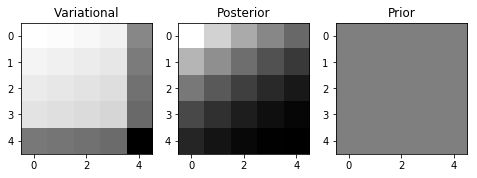

In [4]:
fig, ax_arr = plt.subplots(ncols=3, figsize=(8,4))
# compute the exact parameter posterior
log_posterior = log_softmax(logl_exact + prior_expanded, axis=0).reshape(
    (mbar,)*m.b + (sig2_grid.size,), order='F')[:,:,0] # take slice along first sig2 value
# get the prior and the variational dist
log_prior = prior_expanded.reshape((mbar,)*m.b + (sig2_grid.size,), order='F')[:,:,0] # slice along first sig2 value
log_variational = np.log(KronMatrix(np.expand_dims(Q,axis=2)).expand()).reshape((mbar,)*m.b, order='F')
# get the min and max values of everything so that I can plot it all on the same scale
vmin = np.min(np.hstack((log_posterior, log_prior, log_variational)))
vmax = np.max(np.hstack((log_posterior, log_prior, log_variational)))

# plot
ax_arr[0].imshow(log_variational, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[0].set_title('Variational')
ax_arr[1].imshow(log_posterior, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[1].set_title('Posterior')
ax_arr[2].imshow(log_prior, interpolation='None', cmap='gray_r', vmin=log_prior.min()-0.1, vmax=log_prior.max()+0.1)
ax_arr[2].set_title('Prior')

Compute the posterior mean using the variational distribution. 
We will consider the full support of the variational distribution, i.e. consider every possible set of parameter values.

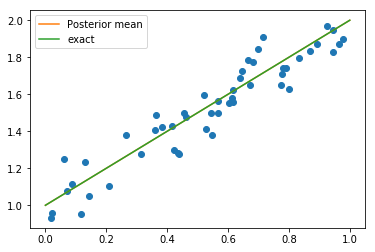

In [5]:
fig, ax = plt.subplots()
ax.plot(x,y,'o')
ax.plot(xx, y_mean, label='Posterior mean')
ax.plot(xx, w_exact*(xx+1.), label='exact')
ax.legend(loc=0)

## Mixture Variational Distribution
### Ensure ELBO Lower bound computed Correctly
compute the exact ELBO with the initialized mixture variational distribution and check if correct.

In [6]:
np.random.seed(0)
tf.reset_default_graph()
n_mix = 5
# create a fake dataset
n = 50
sig2_grid = np.atleast_1d([0.01,0.02])
x = np.random.rand(n,1);
Phi = np.hstack((x, np.ones(x.shape)))
xx = np.linspace(0,1,num=50).reshape((-1,1))
Phi_X = np.hstack((xx, np.ones(xx.shape)))
w_exact = 1.
y = w_exact*np.sum(Phi,axis=1,keepdims=True)
y += np.random.normal(size=(n,1), scale=np.sqrt(sig2_grid[0])) # add some noise

# initialize the W grid, and the prior
wbar = [-1.,-0.5,0.,0.5,1.]
Wbar = np.array([wbar,]*Phi.shape[1])
mbar = Wbar.shape[1]
W = KhatriRaoMeshgrid(Wbar).expand()
sig2_biggrid = np.tile(sig2_grid.reshape((-1,1)),(1,W.shape[1])).reshape(-1) # the sig2 elements correspond to W cols
W = np.tile(W,(1,sig2_grid.size)) # W is repeated the number of times for sig2
P = np.zeros((Phi.shape[1], mbar)) + 1./mbar # prior for weights
psig = np.zeros(sig2_grid.shape) + 1./sig2_grid.size # prior for sig2

# compute the exact log-likelihood
logl_exact = np.zeros((W.shape[1],1))
for i,(w,sig2) in enumerate(zip(W.T, sig2_biggrid)): # loop through each possible set of parameters
    logl_exact[i] = -np.sum(np.power(y-Phi.dot(w.reshape((-1,1))), 2))/(2.*sig2) - n*np.log(sig2)/2
del sig2

# now initialize the model and compute the ELBO with a random initial variational distribution
with tf.Session() as sess:
    m = direct.BayesGLM(Phi=Phi, sig2_grid=sig2_grid, y=y, Wbar=Wbar, logP=np.log(P), logpsig=np.log(psig),n_mixtures=n_mix)
    sess.run(tf.global_variables_initializer())
    assert_array_almost_equal(np.ones((n_mix,m.b)), sess.run(tf.reduce_sum(tf.exp(m.logQ), axis=2)),
                             err_msg="Var dist not normalized correctly.")
    ELBO_LB = sess.run(m.ELBO)
    Q = sess.run(tf.exp(m.logQ))
    A = sess.run(tf.exp(m.logA))
    qsig = sess.run(tf.exp(m.logqsig))
    mix = sess.run(tf.exp(m.log_mix))
    assert_array_almost_equal(1.,mix.sum())

# compute the ELBO manually
prior_expanded = np.kron(psig.reshape((-1,1)), KronMatrix(np.expand_dims(P, axis=2)).expand())
a_expanded = KronMatrix(np.expand_dims(A,axis=2)).expand()
qw_expanded = np.hstack([mi*KronMatrix(np.expand_dims(Qi,axis=2)).expand() # q for latent vars only
               for mi,Qi in zip(mix,Q)]).sum(axis=1, keepdims=True)
q_expanded = np.kron(qsig,qw_expanded)
assert_array_almost_equal(1.,q_expanded.sum())
qTlogq_LB_exact = qsig.T.dot(np.log(qsig)) + \
        qw_expanded.T.dot(np.log(a_expanded) + (qw_expanded-a_expanded)/a_expanded)
ELBO_LB_exact = q_expanded.T.dot(np.log(prior_expanded) + logl_exact) - qTlogq_LB_exact
ELBO_exact = q_expanded.T.dot(np.log(prior_expanded) - np.log(q_expanded) + logl_exact)

assert_array_less(ELBO_LB_exact, ELBO_exact, err_msg="Sanity check: ELBO lower bound not less than ELBO")
assert_array_almost_equal(ELBO_LB_exact, ELBO_LB, err_msg="ELBO LB not computed exactly")
print("test passed.")

[ 17:21:01 ] direct.models INFO: Inititializing model
test passed.


### Optimize
Optimize the variational distribution and ensure it to larger than the initial ELBO

In [7]:
tf.reset_default_graph()
with tf.Session() as sess:
    # reinitialize the model and compute the ELBO with initial variational distribution set to prior
    m = direct.BayesGLM(Phi=Phi, sig2_grid=sig2_grid, y=y,Wbar=Wbar,logP=np.log(P),logpsig=np.log(psig),n_mixtures=n_mix)
    sess.run(tf.global_variables_initializer())
    trace = m.train(n_epochs=1000, sess=sess, display_step=5)
    assert_array_less(ELBO, sess.run(m.ELBO), err_msg="ELBO did not increase in training")
    Q = sess.run(tf.exp(m.logQ))
    qsig = sess.run(tf.exp(m.logqsig))
    mix = sess.run(tf.exp(m.log_mix))
    a_expanded = KronMatrix(np.expand_dims(sess.run(tf.exp(m.logA)),axis=2)).expand()
    y_mean = sess.run(m.predict_mean(Phi_X=Phi_X))

[ 17:21:01 ] direct.models INFO: Inititializing model
[ 17:21:01 ] direct.models INFO: Beginnning training iterations. n_epochs=1000
[ 17:21:01 ] direct.models INFO: using L-BFGS-B optimizer
Epoch: 0001, ELBO: -5644.4411, Time elapsed: 0.1774 seconds.
Epoch: 0005, ELBO: -186.48538, Time elapsed: 0.1816 seconds.
Epoch: 0010, ELBO: 80.729813, Time elapsed: 0.1854 seconds.
Epoch: 0015, ELBO: 82.650035, Time elapsed: 0.1891 seconds.
Epoch: 0020, ELBO: 82.73359, Time elapsed: 0.1953 seconds.
Epoch: 0025, ELBO: 88.908316, Time elapsed: 0.202 seconds.
Epoch: 0030, ELBO: 88.910738, Time elapsed: 0.2062 seconds.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -88.912169
  Number of iterations: 27
  Number of functions evaluations: 34
[ 17:21:02 ] tensorflow INFO: Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -88.912169
  Number of iter

Plot the variational distribution verses the exact posterior. Also plot the prior since this was what the variational distribution was initialized to.

Text(0.5,1,'Prior')

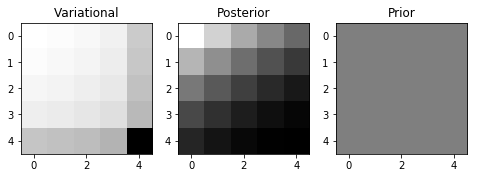

In [8]:
fig, ax_arr = plt.subplots(ncols=3, figsize=(8,4))
# compute the exact parameter posterior
log_posterior = log_softmax(logl_exact + prior_expanded, axis=0).reshape(
    (mbar,)*m.b + (sig2_grid.size,), order='F')[:,:,0] # take slice along first sig2 value
# get the prior and the variational dist
log_prior = prior_expanded.reshape((mbar,)*m.b + (sig2_grid.size,), order='F')[:,:,0] # slice along first sig2 value
# log_variational = np.log(KronMatrix(np.expand_dims(Q,axis=2)).expand()).reshape((mbar,)*m.b, order='F')
log_variational = np.log(np.hstack([mi*KronMatrix(np.expand_dims(Qi,axis=2)).expand()
               for mi,Qi in zip(mix,Q)]).sum(axis=1, keepdims=True)).reshape((mbar,)*m.b, order='F')
# get the min and max values of everything so that I can plot it all on the same scale
vmin = np.min(np.hstack((log_posterior, log_prior, log_variational)))
vmax = np.max(np.hstack((log_posterior, log_prior, log_variational)))

# plot
ax_arr[0].imshow(log_variational, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[0].set_title('Variational')
ax_arr[1].imshow(log_posterior, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[1].set_title('Posterior')
ax_arr[2].imshow(log_prior, interpolation='None', cmap='gray_r', vmin=log_prior.min()-0.1, vmax=log_prior.max()+0.1)
ax_arr[2].set_title('Prior')

Compute the posterior mean using the variational distribution. 
We will consider the full support of the variational distribution, i.e. consider every possible set of parameter values.

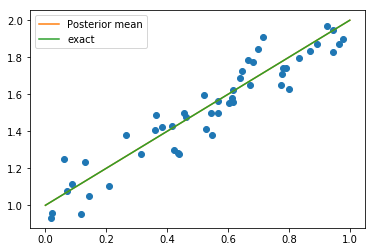

In [9]:
fig, ax = plt.subplots()
ax.plot(x,y,'o')
ax.plot(xx, y_mean, label='Posterior mean')
ax.plot(xx, w_exact*(xx+1.), label='exact')
ax.legend(loc=0)

## Test Sampling a Mixture Distribution
Initialize a random mixture distribution and make sure that the sampling agrees with the exact mixture given a lot of samples.
Also, test evaluating the variational log pdf.

[ 17:21:03 ] direct.models INFO: Inititializing model


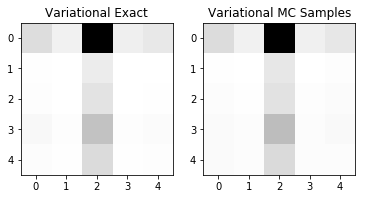

In [10]:
np.random.seed(5)
tf.set_random_seed(5)
fig, ax_arr = plt.subplots(ncols=2, figsize=(6,4))
n_samples = 3000
tf.reset_default_graph()
with tf.Session() as sess:
    m = direct.BayesGLM(Phi=Phi, sig2_grid=sig2_grid, y=y,Wbar=Wbar,logP=np.log(P),logpsig=np.log(psig),
                 logQ=np.random.randn(m.b, m.mbar), n_mixtures=n_mix)
    sess.run(tf.global_variables_initializer())
    # first get the exact log_variational distribution
    Q = sess.run(tf.exp(m.logQ))
    mix = sess.run(tf.exp(m.log_mix))
    q_exact = np.hstack([mi*KronMatrix(np.expand_dims(Qi,axis=2)).expand()
               for mi,Qi in zip(mix,Q)]).sum(axis=1, keepdims=True).reshape((mbar,)*m.b, order='F')
    # then get the estimate from monte-carlo sampling
    w_samples, sig2_samples = sess.run(m.sample_variational(n_samples=n_samples, sample_sig2=True))
    q_mc = np.zeros((mbar,mbar))
    for s in w_samples.T:
        q_mc[s[0], s[1]] += 1./n_samples
    # Test evaluating the variational log pdf at all points in hypothesis space
    mesh = np.hstack([a.reshape((-1,1)) for a in np.meshgrid(
        np.arange(m.mbar), np.arange(m.mbar), np.arange(psig.size))]); mesh = np.asarray(mesh, dtype=np.int32)
    log_var_samples = sess.run(m.log_variational(w=tf.constant(mesh[:,:2].T), sig2=tf.constant(mesh[:,2:].T)))
    logqsig = sess.run(m.logqsig).reshape(-1)
    log_var_samples_exact = np.zeros(mesh.shape[0])
    for i, (w, sig2) in enumerate(zip(mesh[:,:2], mesh[:,2:])):
        log_var_samples_exact[i] = np.log(q_exact.T[w[0],w[1]]) + logqsig[sig2]
    assert_almost_equal(1, np.exp(log_var_samples_exact).sum())
    assert_almost_equal(1, np.exp(log_var_samples).sum())
    assert_array_almost_equal(log_var_samples_exact, log_var_samples)

# plot and make sure sample distribution aggrees
ax_arr[0].imshow(q_exact, interpolation='None', cmap='gray_r')
ax_arr[0].set_title('Variational Exact')
ax_arr[1].imshow(q_mc.T, interpolation='None', cmap='gray_r')
ax_arr[1].set_title('Variational MC Samples');
assert_array_almost_equal(q_exact, q_mc.T, decimal=2)

## Test Optimizing using the REINFORCE Entropy Surrogate

training mixture model
[ 17:21:03 ] direct.models INFO: Inititializing model
[ 17:21:04 ] direct.models INFO: Beginnning training iterations. n_epochs=1000
[ 17:21:04 ] direct.models INFO: using Adam optimizer
Epoch: 0001, loss: 5657.388, Time elapsed: 0.1669 seconds.
Epoch: 0050, loss: 5296.4418, Time elapsed: 0.5122 seconds.
Epoch: 0100, loss: 4954.5074, Time elapsed: 0.8636 seconds.
Epoch: 0150, loss: 4638.0808, Time elapsed: 1.213 seconds.
Epoch: 0200, loss: 4344.2487, Time elapsed: 1.564 seconds.
Epoch: 0250, loss: 4069.6331, Time elapsed: 1.903 seconds.
Epoch: 0300, loss: 3811.1401, Time elapsed: 2.254 seconds.
Epoch: 0350, loss: 3566.6778, Time elapsed: 2.612 seconds.
Epoch: 0400, loss: 3334.9546, Time elapsed: 2.959 seconds.
Epoch: 0450, loss: 3115.4927, Time elapsed: 3.392 seconds.
Epoch: 0500, loss: 2908.2231, Time elapsed: 3.761 seconds.
Epoch: 0550, loss: 2713.4785, Time elapsed: 4.14 seconds.
Epoch: 0600, loss: 2531.4483, Time elapsed: 4.511 seconds.
Epoch: 0650, loss: 236

Text(0.5,1,'Prior')

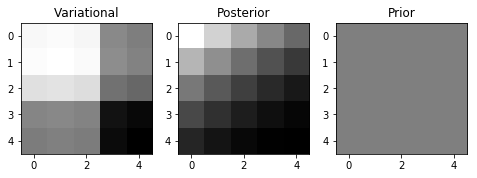

In [11]:
np.random.seed(5)
tf.set_random_seed(5)
tf.reset_default_graph()
n_mix = 5
# now train a mixture model, first optimize with quasi-newton, then finish with SGD
print("training mixture model")
tf.reset_default_graph()
with tf.Session() as sess:
    # reinitialize the model and compute the ELBO with initial variational distribution set to prior
    m = direct.BayesGLM(Phi=Phi, sig2_grid=sig2_grid, y=y,Wbar=Wbar,logP=np.log(P),logpsig=np.log(psig),n_mixtures=n_mix,
                reinforce_entropy=3000)
    sess.run(tf.global_variables_initializer())
    trace = m.train(n_epochs=1000, sess=sess, display_step=50)
    Q = sess.run(tf.exp(m.logQ))
    qsig = sess.run(tf.exp(m.logqsig))
    mix = sess.run(tf.exp(m.log_mix))
    y_mean = sess.run(m.predict_mean(Phi_X=Phi_X))
    
# Plot the variational distribution verses the exact posterior. 
# Also plot the prior since this was what the variational distribution was initialized to. 
fig, ax_arr = plt.subplots(ncols=3, figsize=(8,4))
# compute the exact parameter posterior
log_posterior = log_softmax(logl_exact + prior_expanded, axis=0).reshape(
    (mbar,)*m.b + (sig2_grid.size,), order='F')[:,:,0] # take slice along first sig2 value
# get the prior and the variational dist
log_prior = prior_expanded.reshape((mbar,)*m.b + (sig2_grid.size,), order='F')[:,:,0] # slice along first sig2 value
# log_variational = np.log(KronMatrix(np.expand_dims(Q,axis=2)).expand()).reshape((mbar,)*m.b, order='F')
log_variational = np.log(np.hstack([mi*KronMatrix(np.expand_dims(Qi,axis=2)).expand()
               for mi,Qi in zip(mix,Q)]).sum(axis=1, keepdims=True)).reshape((mbar,)*m.b, order='F')
# get the min and max values of everything so that I can plot it all on the same scale
vmin = np.min(np.hstack((log_posterior, log_prior, log_variational)))
vmax = np.max(np.hstack((log_posterior, log_prior, log_variational)))

# plot
ax_arr[0].imshow(log_variational, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[0].set_title('Variational')
ax_arr[1].imshow(log_posterior, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[1].set_title('Posterior')
ax_arr[2].imshow(log_prior, interpolation='None', cmap='gray_r', vmin=log_prior.min()-0.1, vmax=log_prior.max()+0.1)
ax_arr[2].set_title('Prior')

# More than Two Parameters
Use the RBF RFF's to first solve a toy problem

[ 17:21:13 ] direct.misc INFO: initializing RBF random fourier features
[ 17:21:13 ] direct.models INFO: Inititializing model
[ 17:21:13 ] direct.models INFO: Beginnning training iterations. n_epochs=1000
[ 17:21:13 ] direct.models INFO: using L-BFGS-B optimizer
Epoch: 0001, ELBO: -51.443672, Time elapsed: 0.2924 seconds.
Epoch: 0050, ELBO: -23.100838, Time elapsed: 0.3352 seconds.
Epoch: 0100, ELBO: -22.628477, Time elapsed: 0.3833 seconds.
Epoch: 0150, ELBO: -22.616462, Time elapsed: 0.4356 seconds.
Epoch: 0200, ELBO: -22.615571, Time elapsed: 0.4966 seconds.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22.615526
  Number of iterations: 196
  Number of functions evaluations: 219
[ 17:21:14 ] tensorflow INFO: Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22.615526
  Number of iterations: 196
  Number of functions evaluatio

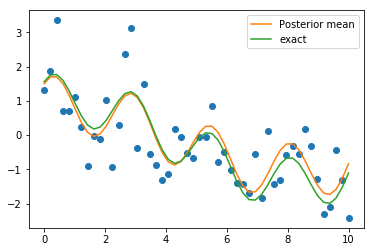

In [12]:
with tf.Session() as sess:
    np.random.seed(5)
    n = 50
    sig2_grid = np.array([0.01, 0.02])*100
    x = np.linspace(0,1,num=n).reshape((-1,1))*10
    xx = np.linspace(0,1,num=50).reshape((-1,1))*10

    # get the features
    kern = RBF_RFFs(1, n_rffs=3)
    Phi = kern.Phi(x)
    Phi_X = kern.Phi(xx)
    sess.run(tf.global_variables_initializer())
    Phi = sess.run(Phi)
    Phi_X = sess.run(Phi_X)

    # initialize the dataset and the model
    w_exact = 0.9
    y = w_exact*np.sum(Phi,axis=1,keepdims=True)
    y += np.random.normal(size=(n,1), scale=np.sqrt(sig2_grid[0])) # add some noise
    Wbar = np.array([[-1.,0.,1.],]*Phi.shape[1])
    logP = np.zeros((Phi.shape[1], Wbar.shape[1])) # uniform prior
    logpsig = np.zeros(sig2_grid.shape) # uniform prior
    m = direct.BayesGLM(Phi=Phi, sig2_grid=sig2_grid, y=y, Wbar=Wbar, logP=logP, logpsig=logpsig, n_mixtures=5)

    # train the model and plot the posterior mean
    sess.run(tf.global_variables_initializer())
    m.train(n_epochs=1000, sess=sess)
    #plt.bar(np.arange(m.n_mixtures), sess.run(tf.exp(m.log_mix)))
    #plt.ylabel("mixture probabilities")
    logQ = sess.run(m.logQ)
    logA = sess.run(m.logA)
    y_mean = sess.run(m.predict_mean(Phi_X=Phi_X))

    fig, ax = plt.subplots()
    ax.plot(x,y,'o')
    ax.plot(xx, y_mean, label='Posterior mean')
    ax.plot(xx, w_exact*np.sum(Phi_X,axis=1,keepdims=True), label='exact')
    ax.legend(loc=0)